In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pyodbc
import sqlite3
import math
import seaborn as sns
import importlib
from scipy.stats import norm
from sklearn.impute import SimpleImputer
import inspect
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import sys
import os
import importlib

# Agregar la ruta de la carpeta Data_CSV al sys.path
sys.path.append(os.path.join(os.getcwd(), 'Data_CSV'))

# Importar y recargar los módulos
import funciones_m


from funciones_m import *  # Importar todas las funciones si es necesario

import funciones_eda

from funciones_eda import *  # Importar todas las funciones si es necesario



## Definición de Objetivo notebook
El objetivo de este notebook es desarrollar un conjunto de datos que permita entrenar un modelo predictivo capaz de estimar los días de incumplimiento de los proveedores de materia prima importada, a partir del análisis de datos históricos. Este modelo busca optimizar la gestión de la cadena de suministro, reduciendo los tiempos improductivos ocasionados por el incumplimiento.

## Campos Originales
- **orden**: numero de orden de compra.
- **linea**: linea de pedido.
- **entrega**: entrega.
- **fecha_ingreso_inventario**: Fecha en la que el material o producto fue ingresado al inventario.
- **fecha_aproximada_necesidad**: Fecha estimada en la que se necesita el material o producto para ser utilizado en la producción.
- **dia_semana_aproximado**: Día de la semana correspondiente a la fecha aproximada de necesidad.
- **mes_aproximado**: Mes correspondiente a la fecha aproximada de necesidad.
- **año_aproximado**: Año correspondiente a la fecha aproximada de necesidad.
- **fecha_entrega_real**: Fecha en la que se recibió la entrega del material o producto, es decir, la fecha efectiva de entrega.
- **nit_proveedor**: Número de Identificación Tributaria (NIT) del proveedor que realizó la entrega.
- **CreationDate_proveedor**: Fecha de creación del registro del proveedor en el sistema.
- **cantidad**: Cantidad de material o producto ordenado.
- **pais**: País de origen del proveedor o de la entrega.
- **forma_envio**: Método de envío utilizado para entregar el material o producto.
- **unidad_de_medida/U**: Unidad de medida utilizada para la cantidad del material.
- **terminos_de_pago**: Condiciones de pago acordadas con el proveedor.
- **categoria_**: Categoría del producto o material solicitado 
- **STATUS_08**: Estado del pedido o de la entrega, que podría indicar si el pedido está en proceso, finalizado, cancelado.
- **cumplio**: Indicador que muestra si el proveedor cumplió
- **dias_diferencia_entrega**: Diferencia en días entre la fecha de entrega real y la fecha de necesidad aproximada, indicando si hubo retraso o si se entregó a tiempo.  (variable a predecir)

## Métrica Calculada
La métrica cumplio se deriva de evaluar si las entregas se realizaron dentro del plazo acordado o si hubo retrasos, la cual permite identificar los patrones de cumplimiento de los proveedores y sirve como una variable categórica clave para modelar la dias_diferencia_entrega, que es la variable objetivo en este análisis.
- **cumplimiento**:  representa (fecha_aproximada_necesidad-fecha_entrega_real) <= 0 'CUMPLIO'
  y si >0 'NO CUMPLIO ', 1 y 0 respectivamente.
- **dias diferencia entrega**: representa la diferencia entre los dias de necesidad y la entrega real (fecha_aproximada_necesidad-fecha_entrega_real)


### ANALISIS EXPLORATORIO 

In [30]:
""" se cargan los datos alamcenados en la carpeta de datos de github"""

csv_path = os.path.join(os.getcwd(), '..', 'Data_CSV', 'data_all.csv')

# Cargar el archivo CSV
df = pd.read_csv(csv_path)
#df=df[df.cumplio==0]


- se cargan los datos alamcenados en la carpeta de datos de github.

In [ ]:
datos_generales(df)
categoricos=categoricas(df)
numeric=numericas(df)

El dataframe tiene 9897 filas y 20 columnas
Las columnas categoricas son: 13
Las columnas numericas son: 7


- se indaga en la dimensionalidad de los datos.

In [32]:
resumen_inicial(df)

,columns,tipo de dato,categorias
0,orden,int64,3119
1,linea,int64,99
2,entrega,int64,9
3,fecha_ingreso_inventario,object,1275
4,fecha_aproximada_necesidad,object,1828
5,dia_semana_aproximado,object,7
6,mes_aproximado,object,12
7,año_aproximado,int64,17
8,fecha_entrega_real,object,1891
9,nit_proveedor,object,284


- tabla donde se verifica el tipo de datos y el numero de categorias por feature.

In [33]:
transfor_fecha(df,['fecha_ingreso_inventario',\
        'fecha_aproximada_necesidad','fecha_entrega_real','CreationDate_proveedor'])

- el codigo transforma tipo de columnas en tipo date.

In [34]:
duplicados(df)

la cantidad de duplicados es: 78


- se verifica el numero de datos duplicados.

In [35]:
df=df.drop_duplicates()

- se eliminan duplicados.

In [36]:
print(df['unidad_de_medida/U'].unique())
df['unidad_de_medida/U'] = df['unidad_de_medida/U'].apply(vacios)

['OZ' 'KG' 'LB' 'UD' '  ']


- esta función se encarga de cambiar los espacios en blanco de la columna 'unidad_de_medida/U' por  valores nullos.

In [37]:
df.isnull().sum()

orden                          0
linea                          0
entrega                        0
fecha_ingreso_inventario       0
fecha_aproximada_necesidad     0
dia_semana_aproximado          0
mes_aproximado                 0
año_aproximado                 0
fecha_entrega_real             0
nit_proveedor                  0
CreationDate_proveedor         0
cantidad                       0
pais                           0
forma_envio                    1
unidad_de_medida/U            23
terminos_de_pago               1
categoria_                     0
STATUS_08                      0
cumplio                        0
dias_diferencia_entrega        0
dtype: int64

- buscar valores nullos en todas las variables.

In [38]:
nullos(df).head(2)

la cantidad de nulos es: 25


,orden,linea,entrega,fecha_ingreso_inventario,fecha_aproximada_necesidad,dia_semana_aproximado,mes_aproximado,año_aproximado,fecha_entrega_real,nit_proveedor,CreationDate_proveedor,cantidad,pais,forma_envio,unidad_de_medida/U,terminos_de_pago,categoria_,STATUS_08,cumplio,dias_diferencia_entrega
767,77724705,1,1,2024-07-30,2024-07-25,Thursday,July,2024,2024-07-25,84352008,2021-08-27 09:29:43.400,1200.0,TAIWAN,AEREO,NaN,GIRO ANTICIPADO,PROGRAMA VARIOS,activo,1,0
2291,77720678,1,1,2023-06-15,2023-06-08,Thursday,June,2023,2023-06-08,611520598,2020-09-08 15:32:13.810,500.0,ESTADOS UNIDOS,AEREO,NaN,A 30 DIAS,PROGRAMA VARIOS,activo,1,0


- Esta función está diseñada para identificar y analizar los valores nulos en un DataFrame.

### ANALITICA DESCRIPTIVA

In [39]:
df=imputar(df)

- esta funcion rellena los valores nullos en un dataframe usando el valor mas frecuente de cada columna, utilizando la funcion de simple imputer de sklearn.

In [40]:
df_=borrar_caracteristicas(df,['orden','linea','entrega','fecha_ingreso_inventario'\
        ,'fecha_aproximada_necesidad','fecha_entrega_real','nit_proveedor',\
    'CreationDate_proveedor','unidad_de_medida/U','STATUS_08','cumplio','año_aproximado'])

In [41]:
modelo=['XGBRegressor()']
feature_importances_df=importance_1(modelo,df_)
feature_importances_df.head(4)

,Variable_Global,Importancia
3,pais,0.4
2,mes,0.2
0,categoria,0.1
1,forma,0.1


- este codigo realiza el entrenamiento de un modelo ML XGBRegressor, el cual se le aplica la variable importance indicando cuanto contribuye cada variable importance indicando cuanto contribuye cada  caracteristica a la prediccion.
se separa las variable resultado con la funcion split('_'), para obtener la variable global de la unicion de la columna y la union de las multiples caracteristicas
del modelo.

In [42]:
modelo_2=['RandomForestRegressor()']
feature_importances_df_=importance_1(modelo_2,df_)
feature_importances_df_.head(4)

,Variable_Global,Importancia
0,cantidad,0.4
1,dia,0.3
2,mes,0.1


- en el analisis de feature importance con el modelo XGBRegressor y RandomForestRegressor, y considernado que el objetivo es entender que factores afectan los tiempos de entrega de proveedores, se observa que las variables país, forma de envío y categoría de proveedor son las más influyentes y comunes en ambos modelos. Estas variables desempeñan un papel crítico en la predicción y análisis de tiempos de entrega, ya que están directamente relacionadas con los aspectos logísticos  y operativos que definen la rapidez y fiabilidad de las entregas.

- basados en el analisis de importancia de las variables, el conjunto de datos  se filtrara utilizando las tres variables, mas influyentes pais, forma de envio y categoria de producto.

In [43]:
tabla__(df,'forma_envio')

,forma_envio,count,acumulado
0,AEREO,6531,66.5
1,MARITIMO,2820,95.2
2,FERREO,292,98.2
3,TERRESTRE,176,100.0


- dado que la forma de envio areo u maritimo representa alrededor del 95%  de los datos,se va centrar el analisis filtrando estas dos formas de envio.

In [44]:
tabla__(df,'pais').head(4)

,pais,count,acumulado
0,ESTADOS UNIDOS,3505,35.7
1,CHINA,3132,67.6
2,ESPAÑA,1080,78.6
3,SOUTH KOREA,637,85.1


- los envios desde estados unidos y china representan el 67.6% de los envios totales y sumando a españa y corea del sur llega al 85 %, por lo que enfocar el analisis en estos cuatro paises permitira estudiar la mayoria de los patrones logisticos. se plantea un analisis combinado entre el pais estados unidos y china, con el fin de entender la dinamica de estos dos paises que por su volumen un impacto mayor.

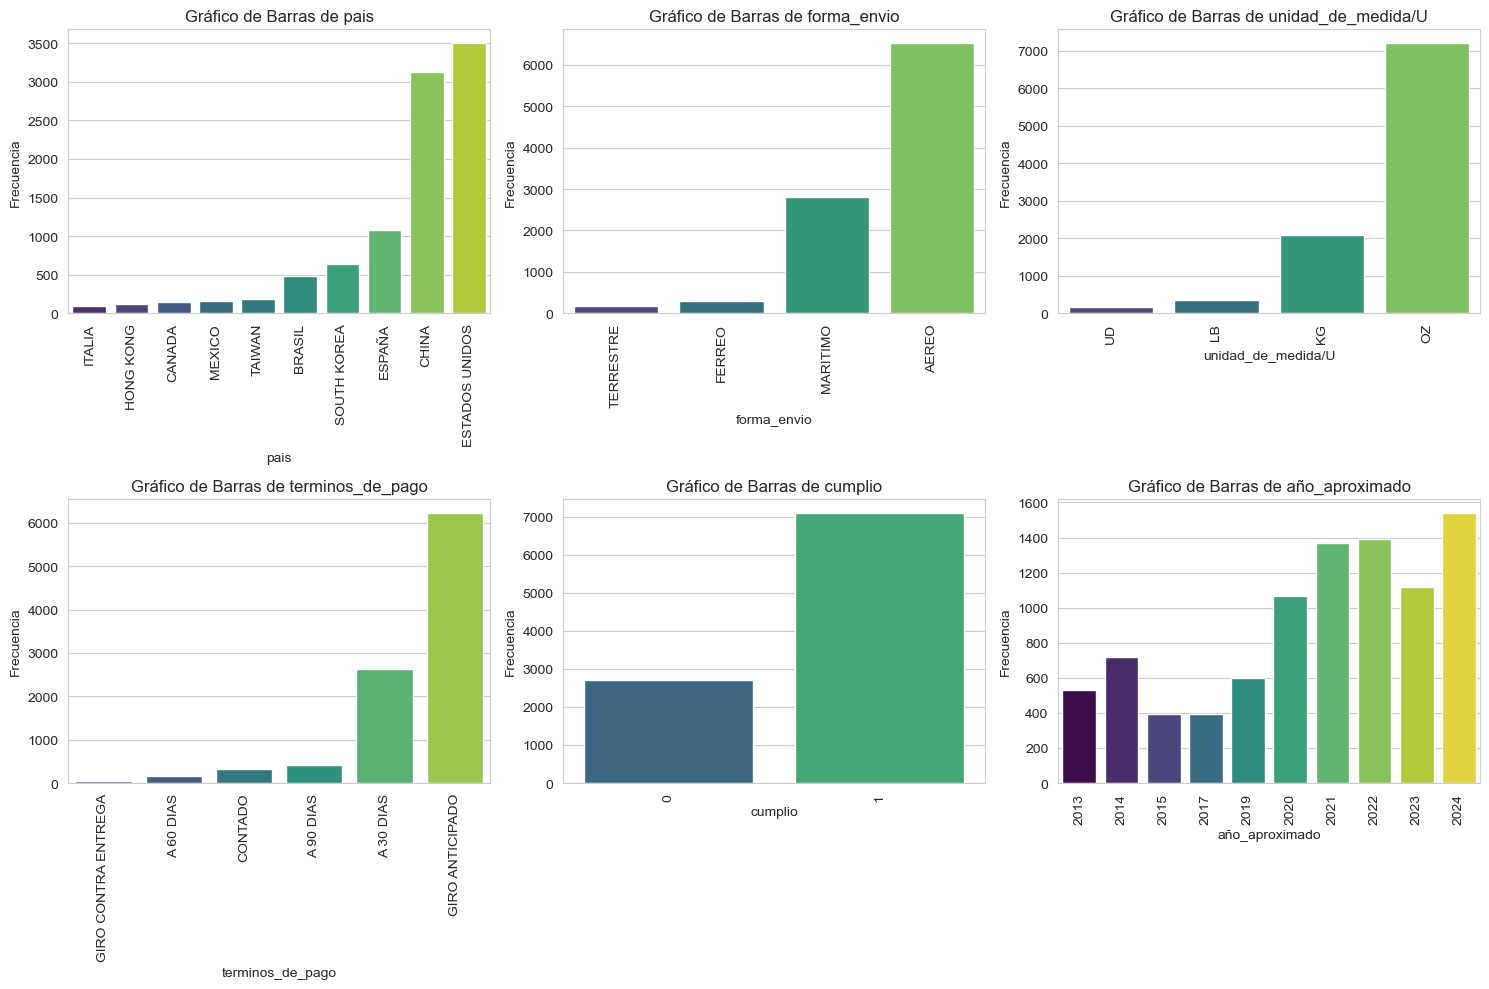

In [45]:
graficar_barras_columnas(df,['pais','forma_envio',\
    'unidad_de_medida/U',\
    'terminos_de_pago','cumplio','año_aproximado'])

In [46]:
df=borrar_caracteristicas(df,['orden','linea','entrega','fecha_ingreso_inventario'\
        ,'fecha_entrega_real','nit_proveedor',\
    'CreationDate_proveedor','STATUS_08'])

### FILTRO DATA SET 

In [47]:
#df_china_usa=df[((df['pais']=='CHINA') | (df['pais']=='ESTADOS UNIDOS')) & ((df['forma_envio']=='MARITIMO') | (df['forma_envio']=='AEREO'))]
df_china=df[df['pais']=='CHINA']
df_usa=df[df['pais']=='ESTADOS UNIDOS']

In [48]:
datos_generales(df_china)
categoricos_=categoricas(df_china)
numeric_=numericas(df_china)

El dataframe tiene 3132 filas y 12 columnas
Las columnas categoricas son: 7
Las columnas numericas son: 4


### Análisis Univariado
Los análisis univariados son fundamentales para entender **cada variable** individualmente, Permiten identificar **patrones, tendencias y outliers** en los datos.

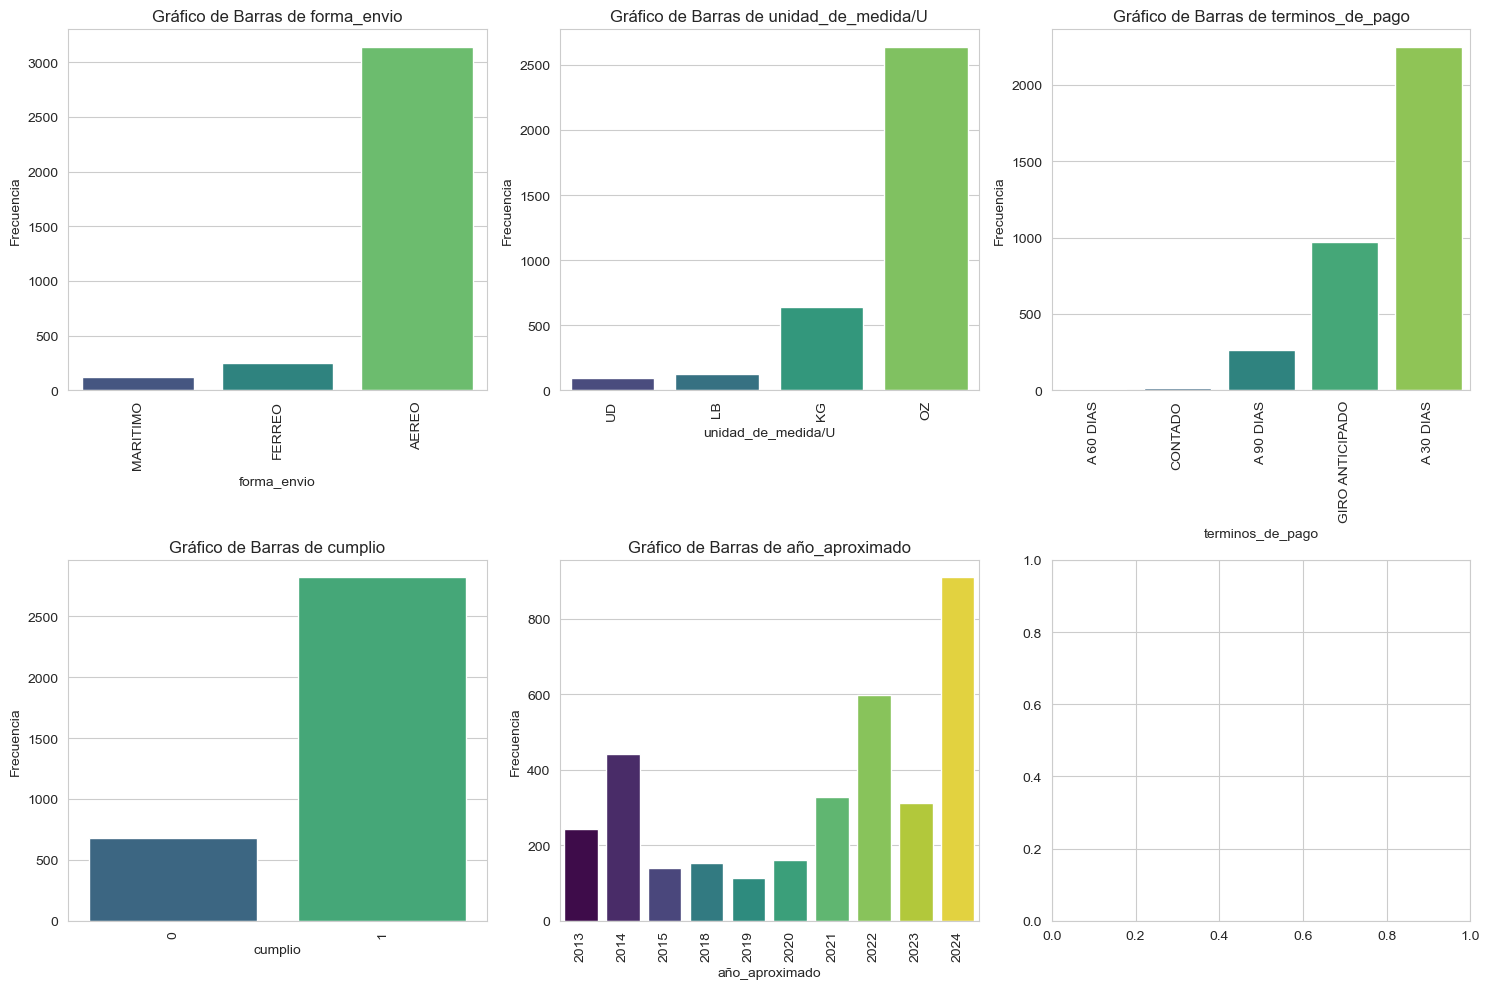

In [49]:
graficar_barras_columnas(df_usa,['forma_envio',\
    'unidad_de_medida/U',\
    'terminos_de_pago','cumplio','año_aproximado'])

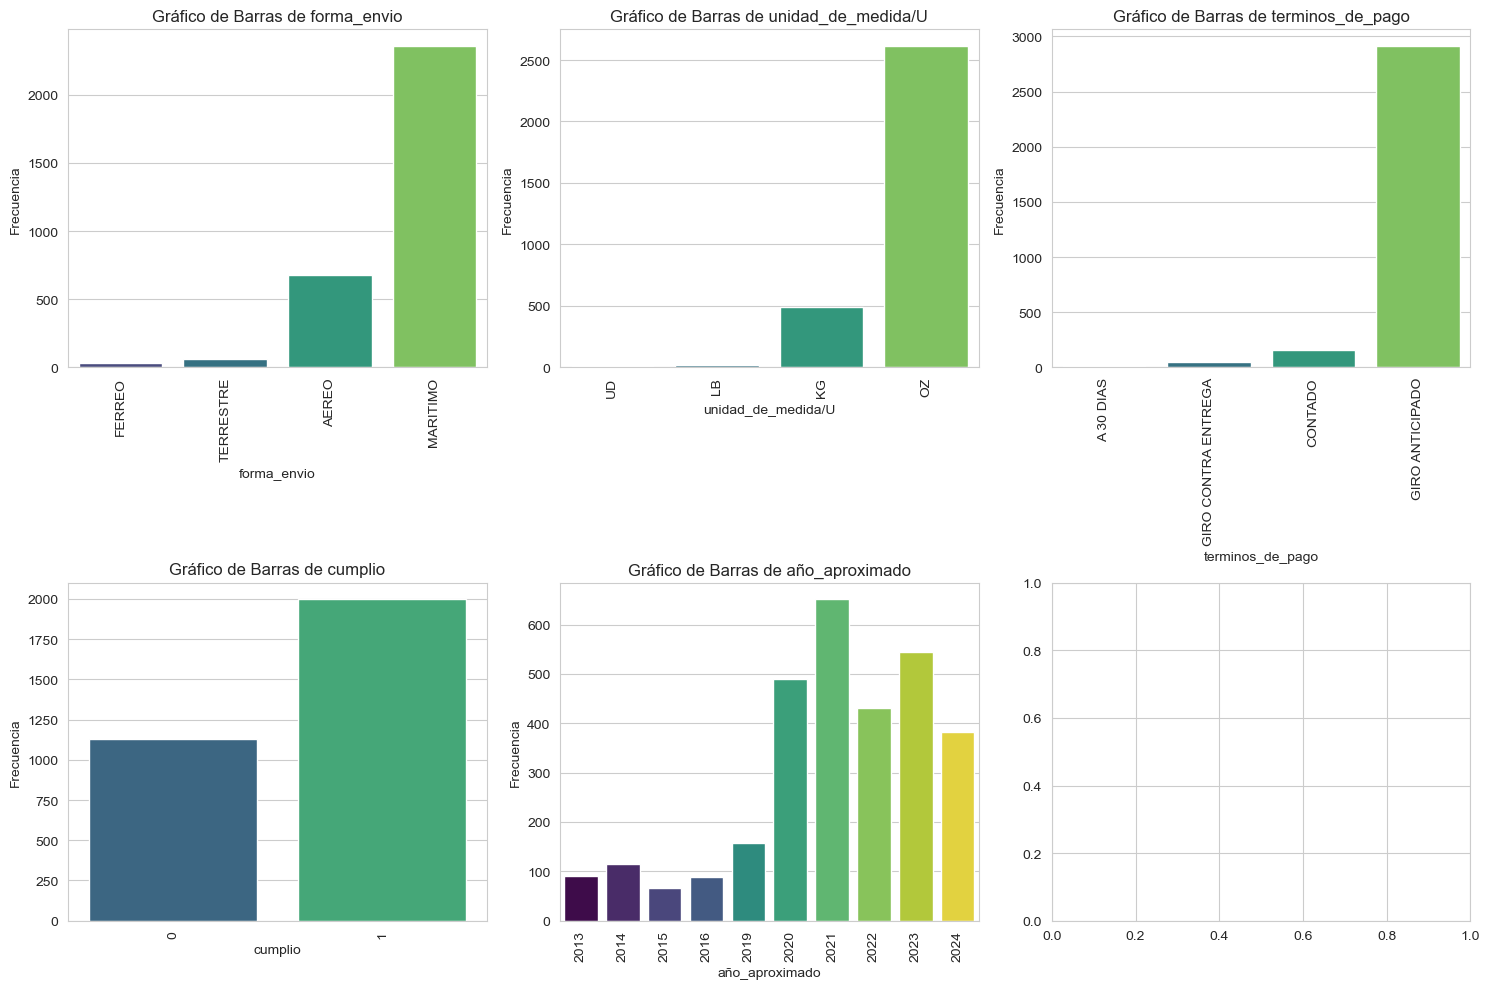

In [50]:
graficar_barras_columnas(df_china,['forma_envio',\
    'unidad_de_medida/U',\
    'terminos_de_pago','cumplio','año_aproximado'])

- la preferencia por el envio maritimo sugiere que los costoss son una consideracion importante, tambien la unidad de OZ indica el enfoque en productos de menor tamaño y peso, por otro lado el pago anticipado sugiere una politica de bajo riesgo enterminos financieros con los proveedores. por otro lado la mayoria de los envios desde china cumplen con los tiempos o requisitos establecidos, con un 63.86% de cumplimiento. este porcentaje sugiere que en general, las operaciones con proveedores  desde china son confiables sin embargo, el 36.14% de incumplimiento es relativamente alto el cual representa una area de oportunidad, tambien hubo un crecimiento significativo de las importaciones desde china apartir desde el 2020 observando una estabilizacion de los registros desde ese año.

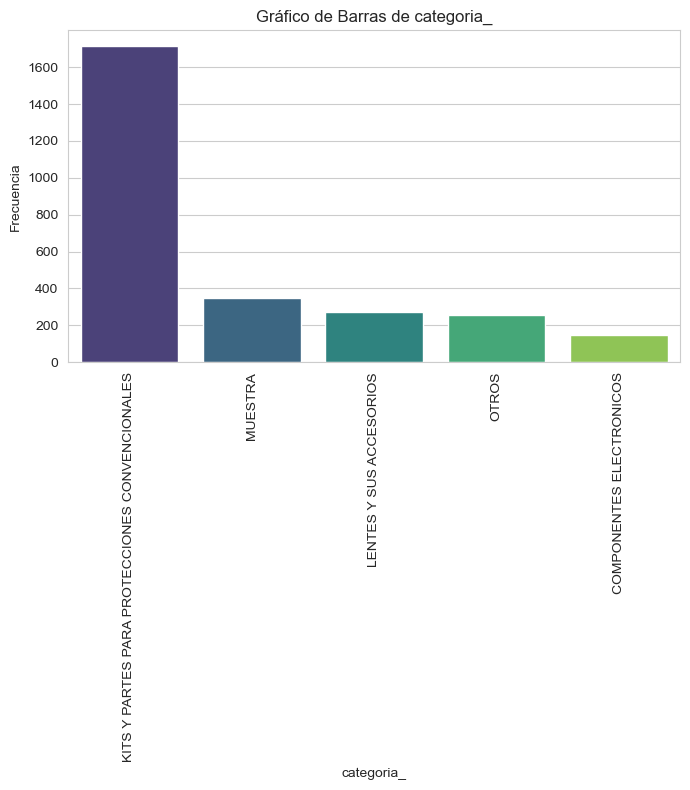

,categoria_,Frecuencia_acumulada
0,KITS Y PARTES PARA PROTECCIONES CONVENCIONALES,62.62
1,MUESTRA,75.33
2,LENTES Y SUS ACCESORIOS,85.30
3,OTROS,94.58
4,COMPONENTES ELECTRONICOS,99.99


In [51]:
tabla_(df_china,'categoria_',5)

- en el grupo de categorias de " KITS Y PARTES PARA PROTECCIONES CONVENCIONALES", " MUESTRA", "LENTES Y SUS ACCESORIOS", "OTROS" y "ELECTRONICOS"  representa la mayor parte del total, por lo que el analisis deberia priorizar el abastecimiento para estas categorias, haciendo una salvedad de la categoria muestras, ya que no representa un material solicitado directamente para las ordenes de produccion, estas muestras son utilizadas por el area de I+D  para experimentar en mejoras o nuevos productos.

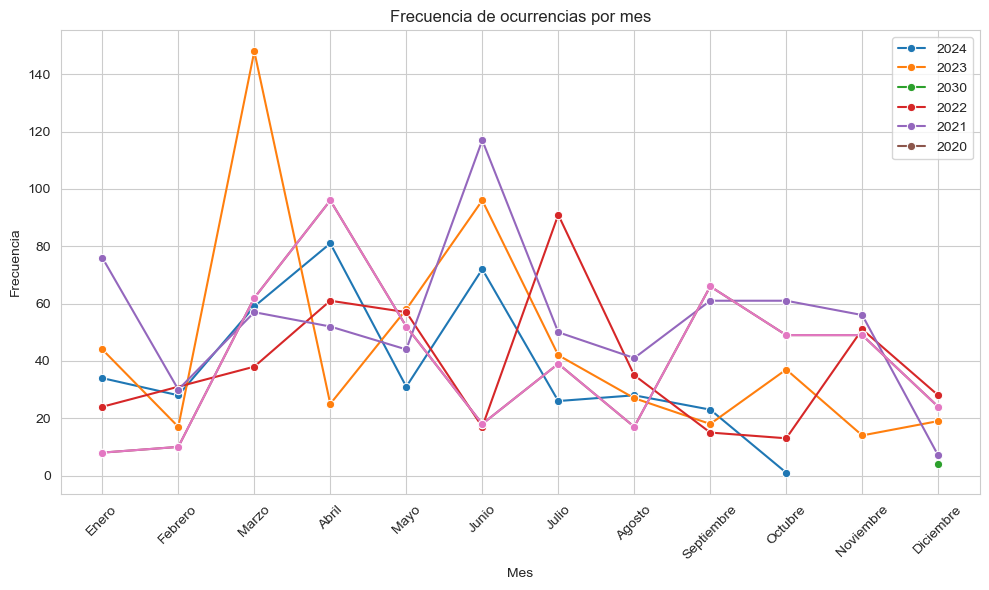

In [52]:
lineas_meses_año(df_china,'fecha_aproximada_necesidad')

- este analisis muestra que las importaciones de materia prima desde china tienen cierta estacionalidad con picos en ciertos meses como marzo y junio y bajas actividades como febrero, octubre y diciembre. ademas, el año 2023 presenta un pico inusual alto en el mes de marzo en comparacion con los otros años.

- algunas propuestas posteriores es separar el año 2023 para un anlisis especifico de este año y tambien es recomendable utilizar feature enginering con el fin de crear nuevas variables que puedan explicar de mejor forma la estacionalidad de las importaciones en el modelo.

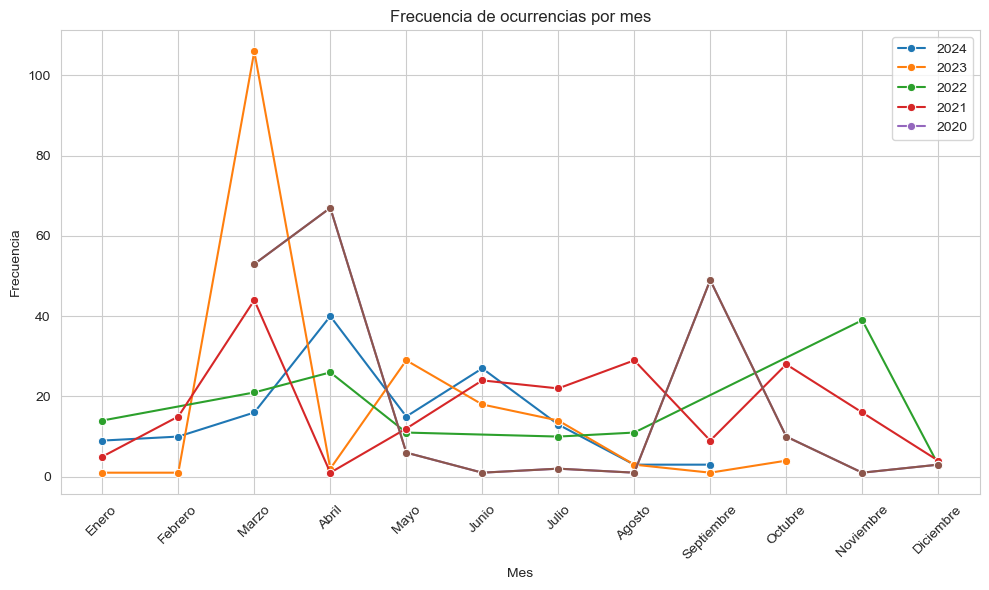

In [53]:
df_incumplio=df_china[df_china['cumplio']!=1]
lineas_meses_año(df_incumplio,'fecha_aproximada_necesidad')

- se observan picos notables de incumplimiento en ciertos meses, especialmente en marzo del año 2023  y en abril del 2020, sin embargo cada año muestra una distribucion diferente a lo largo de los meses por ejemplo para el 2020 en septiembre se presenta otro pico, para el años 2022 y 2024 tiene una distribucion mas equilibrada con fluctuaciones menores a lo largo del año.

- algunos meses como junio y diciembre tienen frecuencia bajas en incumplimiento en la mayoria de años.

- se recomienda hacer dos enfoques de modelo uno seleccionando el mes de marzo del 2023 y otro sin este dato y evaluar que modelo es capaz de generalizar mejor teniendo en cuenta este pico.

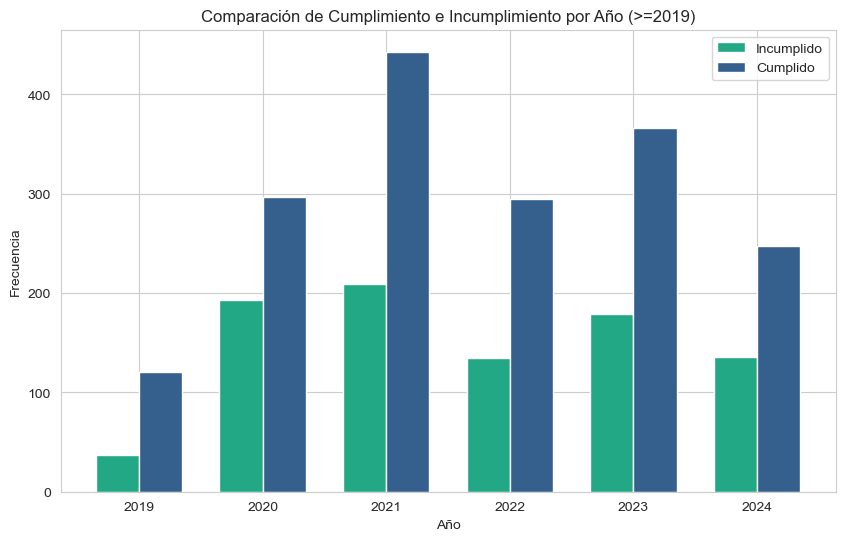

In [54]:
grafica_de_barras_compracion(df_china)

- para el año 2021 se observa un pico de cumplimiento es significativamente mayor comparado con los otros años, para los años 2020 y 2021 la frecuencia de incumplimiento fueron mayores a comparacion con los otros años, y para el año 2022 y 2024 las frecuencias de incumplimiento disminuyeron.

- a lo largo de los años, se observa que el incumplimiento es constante, lo que sugiere que hay entregas que no se logran entregar independientemente del año. 

- se recomienda hacer un analisis separados de los cumplimientos ya que los factores o las condiciones para ambos cumplimientos pueden ser distintas, por lo que analizar especificamente los incumplimientos, ayudando al modelo a identificar los patrones especificos de los dias de incumplimiento.

In [55]:
df_china.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3132 entries, 4 to 9791
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   fecha_aproximada_necesidad  3132 non-null   datetime64[ns]
 1   dia_semana_aproximado       3132 non-null   object        
 2   mes_aproximado              3132 non-null   object        
 3   año_aproximado              3132 non-null   int64         
 4   cantidad                    3132 non-null   float64       
 5   pais                        3132 non-null   object        
 6   forma_envio                 3132 non-null   object        
 7   unidad_de_medida/U          3132 non-null   object        
 8   terminos_de_pago            3132 non-null   object        
 9   categoria_                  3132 non-null   object        
 10  cumplio                     3132 non-null   int64         
 11  dias_diferencia_entrega     3132 non-null   int64         
dt

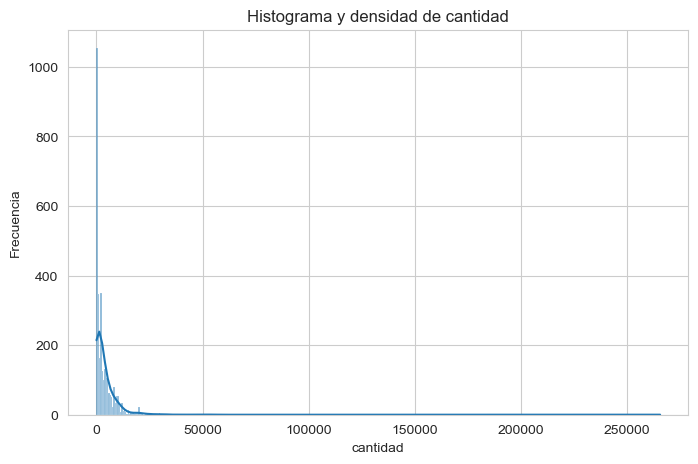

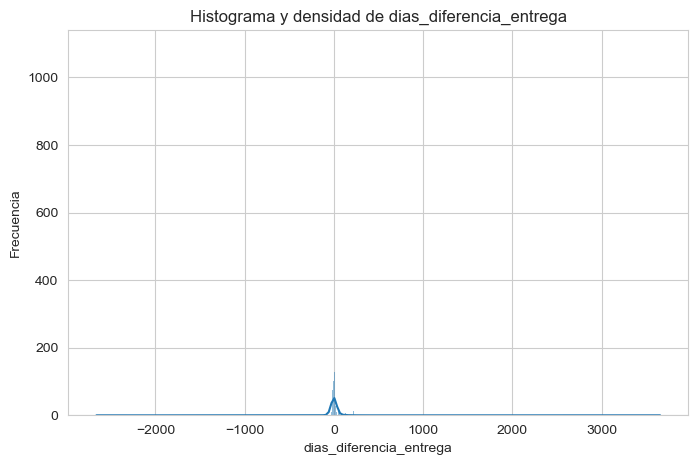

In [56]:
# Histogramas para las variables numéricas
numerical_columns = ['cantidad', 'dias_diferencia_entrega']
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_china[column], kde=True)
    plt.title(f'Histograma y densidad de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

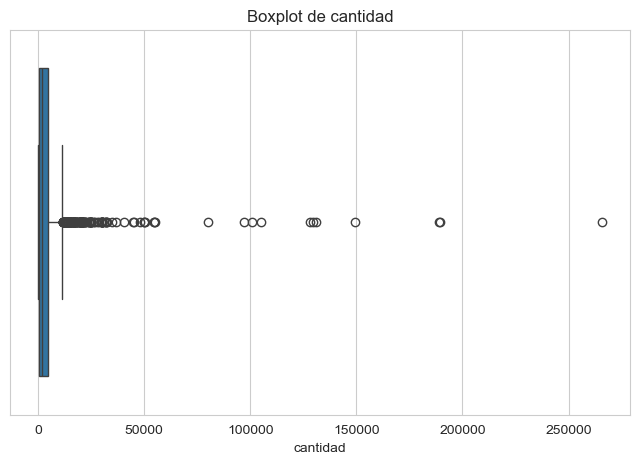

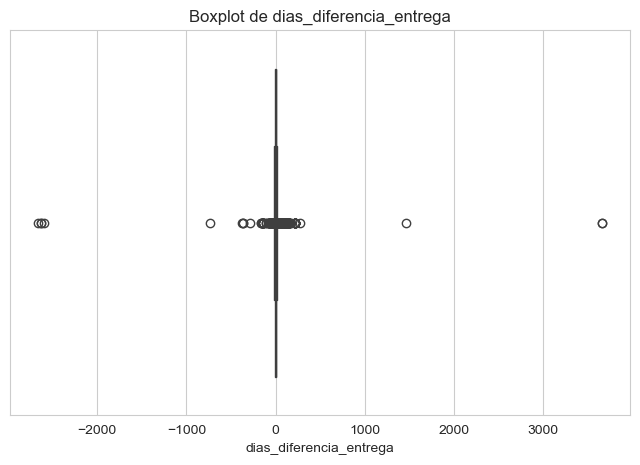

In [57]:
# Gráficos de Cajas (Boxplots) para detectar outliers
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_china[column])
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
    plt.show()

El histograma muestra que la mayoría de los valores de cantidad son bajos, pero hay algunos valores muy altos (outliers) que distorsionan la distribución hacia la derecha. La distribución es asimétrica y presenta muchos valores pequeños con unos pocos valores extremadamente grandes. Se recomienda considerar una transformación logarítmica para normalizar los datos y analizar más a fondo los outliers, ya que podrían ser errores o requerir atención especia

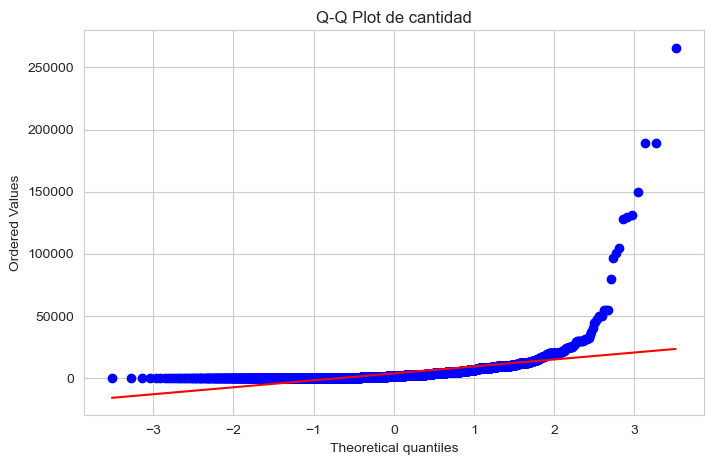

Prueba de Shapiro-Wilk para cantidad: Estadístico=0.2993902564048767, p-valor=0.0
cantidad no sigue una distribución normal (se rechaza la hipótesis nula)


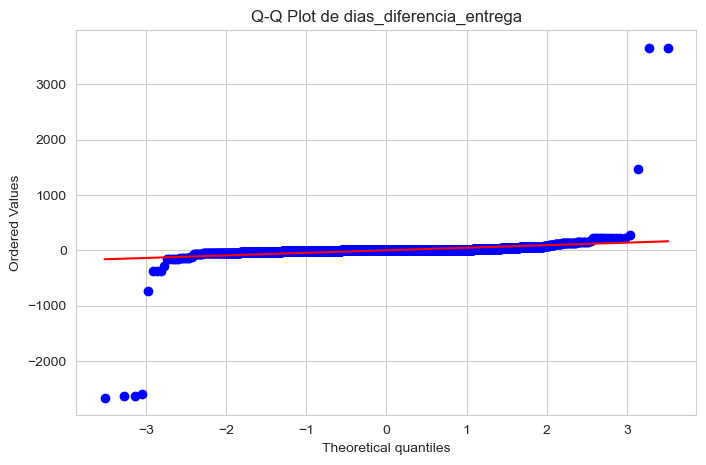

Prueba de Shapiro-Wilk para dias_diferencia_entrega: Estadístico=0.11327612400054932, p-valor=0.0
dias_diferencia_entrega no sigue una distribución normal (se rechaza la hipótesis nula)
Estadísticas descriptivas:
            cantidad  dias_diferencia_entrega
count    3132.000000              3132.000000
mean     4003.424804                 2.429438
std     10249.668888               138.799407
min         1.000000             -2660.000000
25%       300.000000                -4.000000
50%      1830.500000                 0.000000
75%      4800.000000                 6.000000
max    265700.000000              3656.000000
cantidad - Asimetría: 13.205641834175488, Curtosis: 246.26873253059355
dias_diferencia_entrega - Asimetría: 3.2625497656126496, Curtosis: 473.32143862354627


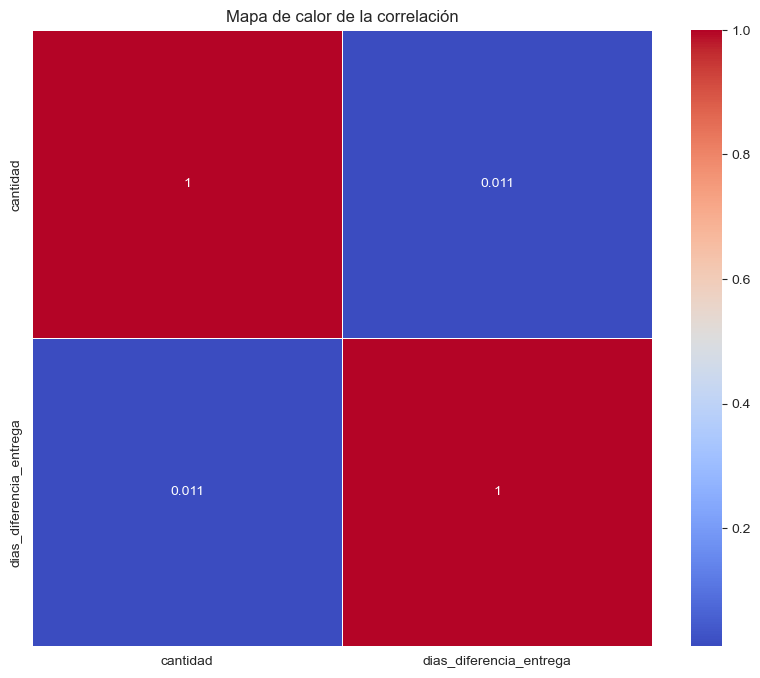

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Verificación de normalidad con Q-Q plots y Shapiro-Wilk
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    stats.probplot(df_china[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot de {column}')
    plt.show()

    # Prueba de Shapiro-Wilk
    stat, p = stats.shapiro(df_china[column])
    print(f'Prueba de Shapiro-Wilk para {column}: Estadístico={stat}, p-valor={p}')
    if p > 0.05:
        print(f'{column} parece seguir una distribución normal (no se rechaza la hipótesis nula)')
    else:
        print(f'{column} no sigue una distribución normal (se rechaza la hipótesis nula)')

# Estadísticas Descriptivas
desc_stats = df_china[numerical_columns].describe()
print("Estadísticas descriptivas:")
print(desc_stats)

# Asimetría y Curtosis
for column in numerical_columns:
    skewness = df_china[column].skew()
    kurtosis = df_china[column].kurt()
    print(f'{column} - Asimetría: {skewness}, Curtosis: {kurtosis}')

# Análisis de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_china[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de la correlación')
plt.show()


**ANALISIS PARA EL DATAFRAME China**

Variable `cantidad`
- **No sigue una distribución normal:** Los puntos se desvían mucho de la línea roja, especialmente en los valores altos, indicando que cantidad no tiene una distribución normal.
- **Outliers y Asimetría:** La presencia de valores altos muy alejados sugiere que hay outliers y que la distribución es asimétrica.

variable `dias_diferencia_entrega`
- **No sigue una distribución normal:** Los puntos se desvían de la línea roja, especialmente en los extremos, indicando que la variable no sigue una distribución normal.
- **Presencia de Outliers:** Se observan valores extremos tanto en el extremo superior como en el inferior, lo cual indica posibles outliers significativos.

In [59]:
df_incumplio.info()
df_incumplio

<class 'pandas.core.frame.DataFrame'>
Index: 1132 entries, 4 to 9791
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   fecha_aproximada_necesidad  1132 non-null   datetime64[ns]
 1   dia_semana_aproximado       1132 non-null   object        
 2   mes_aproximado              1132 non-null   object        
 3   año_aproximado              1132 non-null   int64         
 4   cantidad                    1132 non-null   float64       
 5   pais                        1132 non-null   object        
 6   forma_envio                 1132 non-null   object        
 7   unidad_de_medida/U          1132 non-null   object        
 8   terminos_de_pago            1132 non-null   object        
 9   categoria_                  1132 non-null   object        
 10  cumplio                     1132 non-null   int64         
 11  dias_diferencia_entrega     1132 non-null   int64         
dt

,fecha_aproximada_necesidad,dia_semana_aproximado,mes_aproximado,año_aproximado,cantidad,pais,forma_envio,unidad_de_medida/U,terminos_de_pago,categoria_,cumplio,dias_diferencia_entrega
4,2024-09-16,Monday,September,2024,105.0,CHINA,MARITIMO,OZ,GIRO ANTICIPADO,REPRESENTACIONES,0,3
105,2024-09-12,Thursday,September,2024,210.0,CHINA,AEREO,OZ,GIRO ANTICIPADO,PROGRAMA VARIOS,0,15
112,2024-09-12,Thursday,September,2024,150.0,CHINA,AEREO,OZ,GIRO ANTICIPADO,COMPONENTES ELECTRONICOS,0,15
125,2024-08-10,Saturday,August,2024,6400.0,CHINA,MARITIMO,OZ,CONTADO,KITS Y PARTES PARA PROTECCIONES CONVENCIONALES,0,4
128,2024-07-19,Friday,July,2024,200.0,CHINA,MARITIMO,OZ,GIRO ANTICIPADO,OTROS,0,45
...,...,...,...,...,...,...,...,...,...,...,...,...
9787,2013-03-06,Wednesday,March,2013,500.0,CHINA,AEREO,OZ,GIRO ANTICIPADO,OTROS,0,2
9788,2013-01-23,Wednesday,January,2013,2037.0,CHINA,MARITIMO,OZ,GIRO ANTICIPADO,BOBINAS Y DISCOS DE ALUMINIO,0,11
9789,2013-01-23,Wednesday,January,2013,8464.0,CHINA,MARITIMO,OZ,GIRO ANTICIPADO,BOBINAS Y DISCOS DE ALUMINIO,0,11
9790,2013-01-23,Wednesday,January,2013,10853.0,CHINA,MARITIMO,LB,GIRO ANTICIPADO,BOBINAS Y DISCOS DE ALUMINIO,0,11


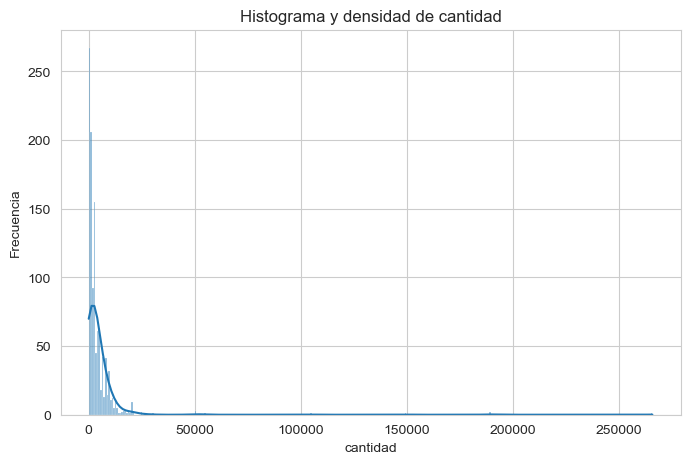

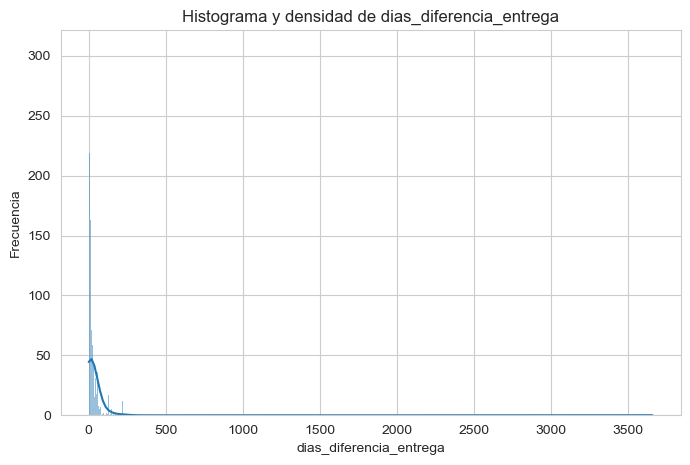

In [60]:
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_incumplio[column], kde=True)
    plt.title(f'Histograma y densidad de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

Nuevamente se observan valores muy altos en terminos tanto de los días como de la variable de cantidad; ahora pasamos nuavemnete analizarlos meidante pruebas de normalidad

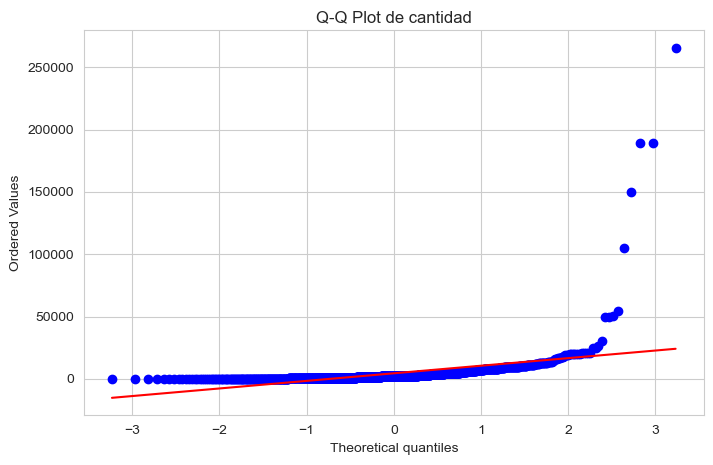

Prueba de Shapiro-Wilk para cantidad: Estadístico=0.21685850620269775, p-valor=0.0
cantidad no sigue una distribución normal (se rechaza la hipótesis nula)


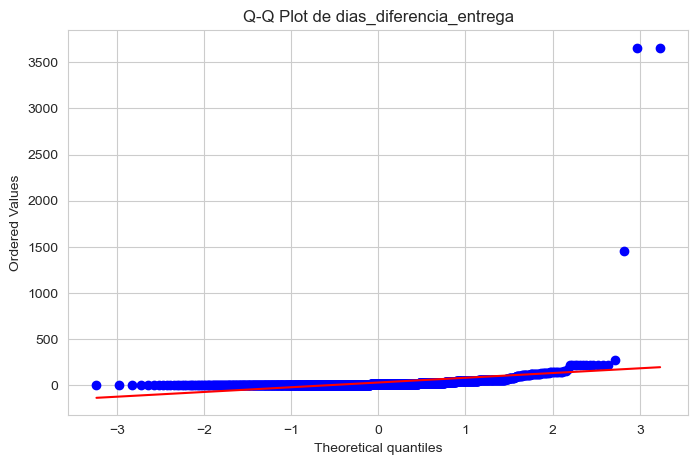

Prueba de Shapiro-Wilk para dias_diferencia_entrega: Estadístico=0.10283058881759644, p-valor=0.0
dias_diferencia_entrega no sigue una distribución normal (se rechaza la hipótesis nula)
Estadísticas descriptivas:
            cantidad  dias_diferencia_entrega
count    1132.000000              1132.000000
mean     4438.570671                32.386042
std     13167.188545               162.306176
min         1.000000                 1.000000
25%       800.000000                 5.000000
50%      2349.000000                12.000000
75%      4802.750000                30.000000
max    265700.000000              3656.000000
cantidad - Asimetría: 13.597495766600018, Curtosis: 220.42334693106451
dias_diferencia_entrega - Asimetría: 20.319686464280696, Curtosis: 443.29849766315976


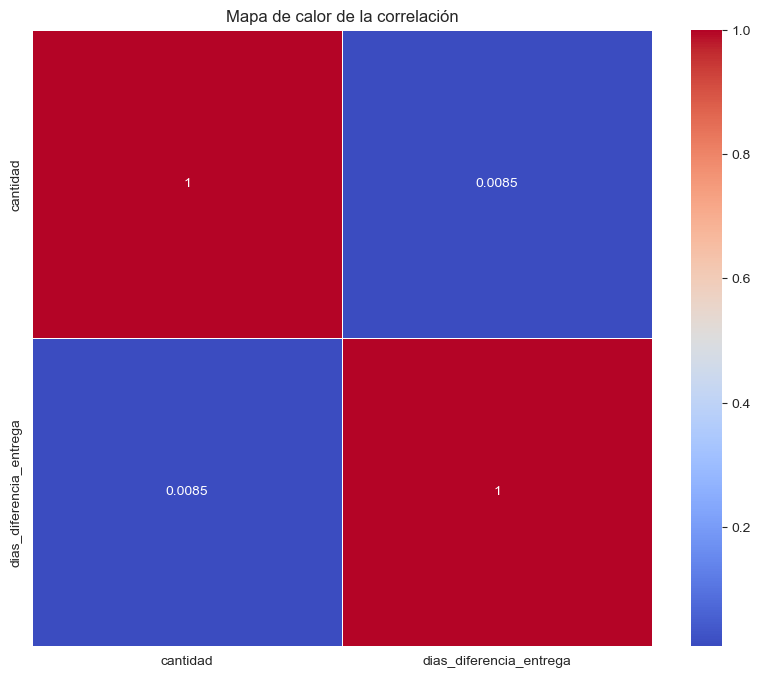

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Verificación de normalidad con Q-Q plots y Shapiro-Wilk
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    stats.probplot(df_incumplio[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot de {column}')
    plt.show()

    # Prueba de Shapiro-Wilk
    stat, p = stats.shapiro(df_incumplio[column])
    print(f'Prueba de Shapiro-Wilk para {column}: Estadístico={stat}, p-valor={p}')
    if p > 0.05:
        print(f'{column} parece seguir una distribución normal (no se rechaza la hipótesis nula)')
    else:
        print(f'{column} no sigue una distribución normal (se rechaza la hipótesis nula)')

# Estadísticas Descriptivas
desc_stats = df_incumplio[numerical_columns].describe()
print("Estadísticas descriptivas:")
print(desc_stats)

# Asimetría y Curtosis
for column in numerical_columns:
    skewness = df_incumplio[column].skew()
    kurtosis = df_incumplio[column].kurt()
    print(f'{column} - Asimetría: {skewness}, Curtosis: {kurtosis}')

# Análisis de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_incumplio[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de la correlación')
plt.show()

Nuevamente visualizamos los datos e identificamos los vaolores atipicos en una  boxplot 

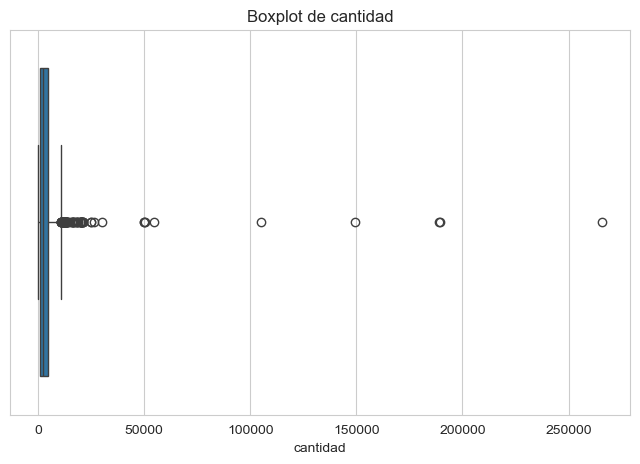

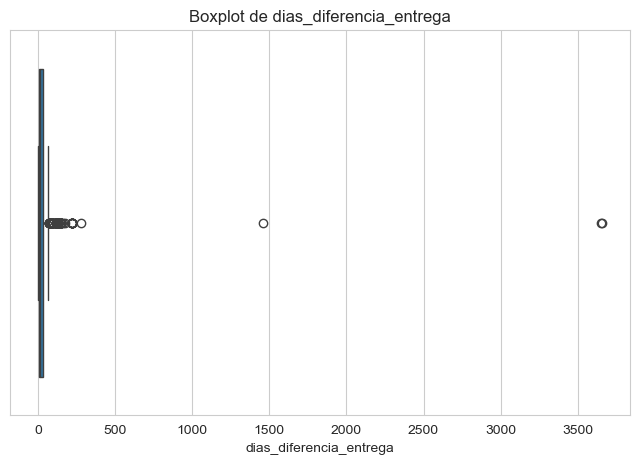

In [62]:
# Gráficos de Cajas (Boxplots) para detectar outliers
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_incumplio[column])
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
    plt.show()

In [63]:
df_incumplio = df_incumplio[(df_incumplio['dias_diferencia_entrega'] < 500) & (df_incumplio['cantidad'] < 50000)]
df_incumplio

,fecha_aproximada_necesidad,dia_semana_aproximado,mes_aproximado,año_aproximado,cantidad,pais,forma_envio,unidad_de_medida/U,terminos_de_pago,categoria_,cumplio,dias_diferencia_entrega
4,2024-09-16,Monday,September,2024,105.0,CHINA,MARITIMO,OZ,GIRO ANTICIPADO,REPRESENTACIONES,0,3
105,2024-09-12,Thursday,September,2024,210.0,CHINA,AEREO,OZ,GIRO ANTICIPADO,PROGRAMA VARIOS,0,15
112,2024-09-12,Thursday,September,2024,150.0,CHINA,AEREO,OZ,GIRO ANTICIPADO,COMPONENTES ELECTRONICOS,0,15
125,2024-08-10,Saturday,August,2024,6400.0,CHINA,MARITIMO,OZ,CONTADO,KITS Y PARTES PARA PROTECCIONES CONVENCIONALES,0,4
128,2024-07-19,Friday,July,2024,200.0,CHINA,MARITIMO,OZ,GIRO ANTICIPADO,OTROS,0,45
...,...,...,...,...,...,...,...,...,...,...,...,...
9787,2013-03-06,Wednesday,March,2013,500.0,CHINA,AEREO,OZ,GIRO ANTICIPADO,OTROS,0,2
9788,2013-01-23,Wednesday,January,2013,2037.0,CHINA,MARITIMO,OZ,GIRO ANTICIPADO,BOBINAS Y DISCOS DE ALUMINIO,0,11
9789,2013-01-23,Wednesday,January,2013,8464.0,CHINA,MARITIMO,OZ,GIRO ANTICIPADO,BOBINAS Y DISCOS DE ALUMINIO,0,11
9790,2013-01-23,Wednesday,January,2013,10853.0,CHINA,MARITIMO,LB,GIRO ANTICIPADO,BOBINAS Y DISCOS DE ALUMINIO,0,11


In [64]:
df_incumplio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1120 entries, 4 to 9791
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   fecha_aproximada_necesidad  1120 non-null   datetime64[ns]
 1   dia_semana_aproximado       1120 non-null   object        
 2   mes_aproximado              1120 non-null   object        
 3   año_aproximado              1120 non-null   int64         
 4   cantidad                    1120 non-null   float64       
 5   pais                        1120 non-null   object        
 6   forma_envio                 1120 non-null   object        
 7   unidad_de_medida/U          1120 non-null   object        
 8   terminos_de_pago            1120 non-null   object        
 9   categoria_                  1120 non-null   object        
 10  cumplio                     1120 non-null   int64         
 11  dias_diferencia_entrega     1120 non-null   int64         
dt

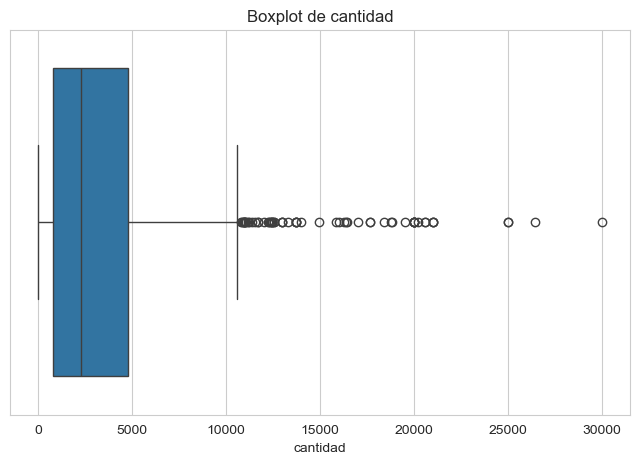

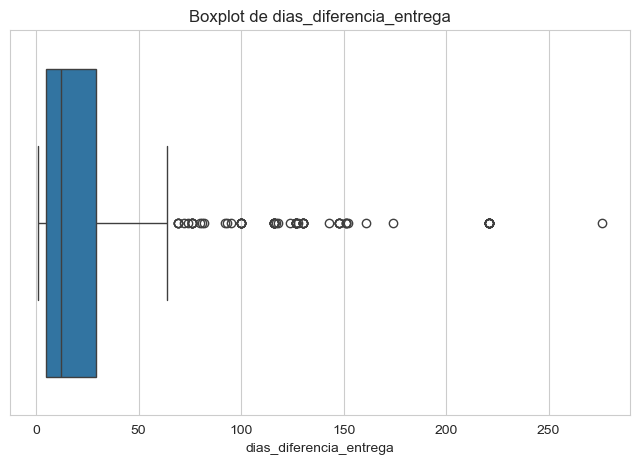

In [65]:
# Gráficos de Cajas (Boxplots) para detectar outliers
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_incumplio[column])
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
    plt.show()

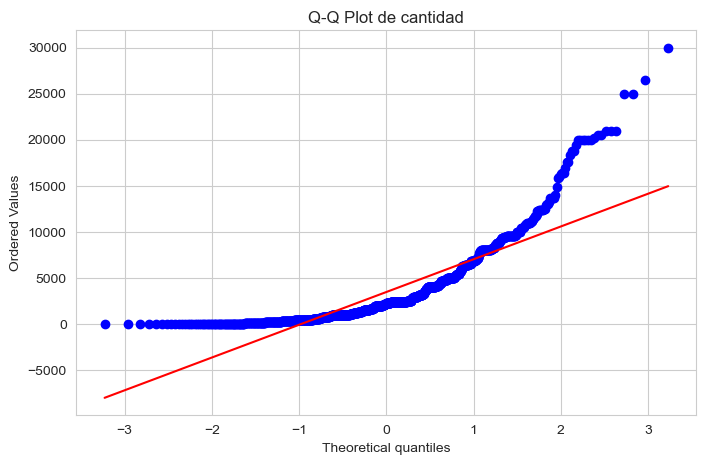

Prueba de Shapiro-Wilk para cantidad: Estadístico=0.7586848735809326, p-valor=1.3978806413183903e-37
cantidad no sigue una distribución normal (se rechaza la hipótesis nula)


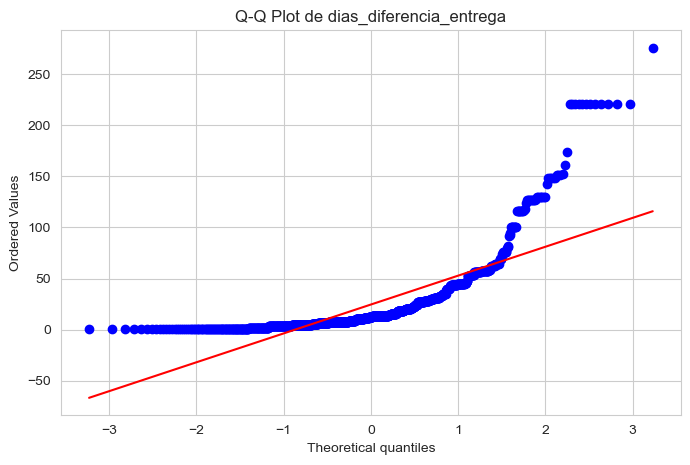

Prueba de Shapiro-Wilk para dias_diferencia_entrega: Estadístico=0.6217488050460815, p-valor=4.344025239406933e-44
dias_diferencia_entrega no sigue una distribución normal (se rechaza la hipótesis nula)
Estadísticas descriptivas:
           cantidad  dias_diferencia_entrega
count   1120.000000              1120.000000
mean    3496.243750                24.512500
std     4076.487413                35.838405
min        1.000000                 1.000000
25%      800.000000                 5.000000
50%     2260.000000                12.000000
75%     4800.000000                29.000000
max    30000.000000               276.000000
cantidad - Asimetría: 2.273660214117396, Curtosis: 6.756927441211981
dias_diferencia_entrega - Asimetría: 3.202189308059485, Curtosis: 12.526621486131646


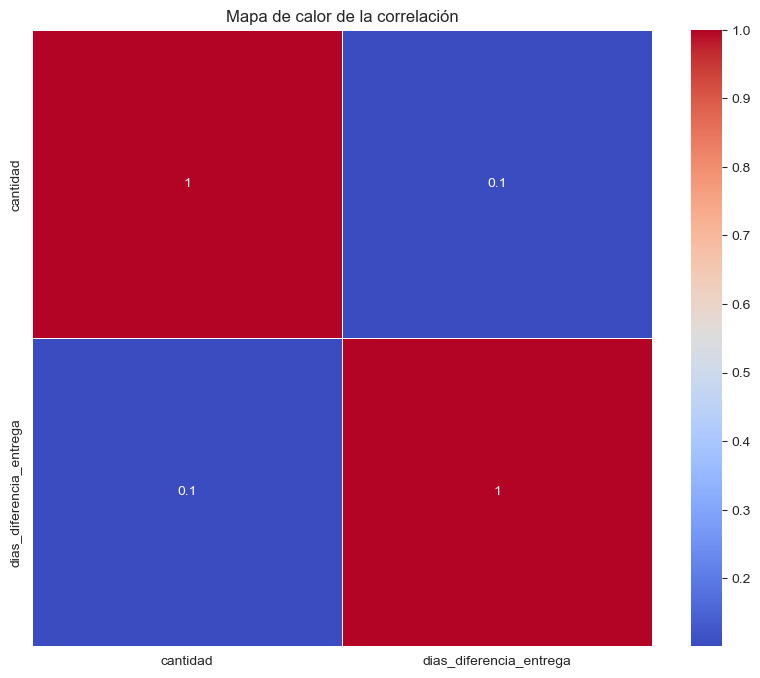

In [66]:
# Verificación de normalidad con Q-Q plots y Shapiro-Wilk
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    stats.probplot(df_incumplio[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot de {column}')
    plt.show()

    # Prueba de Shapiro-Wilk
    stat, p = stats.shapiro(df_incumplio[column])
    print(f'Prueba de Shapiro-Wilk para {column}: Estadístico={stat}, p-valor={p}')
    if p > 0.05:
        print(f'{column} parece seguir una distribución normal (no se rechaza la hipótesis nula)')
    else:
        print(f'{column} no sigue una distribución normal (se rechaza la hipótesis nula)')

# Estadísticas Descriptivas
desc_stats = df_incumplio[numerical_columns].describe()
print("Estadísticas descriptivas:")
print(desc_stats)

# Asimetría y Curtosis
for column in numerical_columns:
    skewness = df_incumplio[column].skew()
    kurtosis = df_incumplio[column].kurt()
    print(f'{column} - Asimetría: {skewness}, Curtosis: {kurtosis}')

# Análisis de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_incumplio[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de la correlación')
plt.show()

In [67]:
df_incumplio = df_incumplio[(df_incumplio['dias_diferencia_entrega'] < 160) & (df_incumplio['cantidad'] < 23000)]


In [68]:
df_incumplio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1101 entries, 4 to 9791
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   fecha_aproximada_necesidad  1101 non-null   datetime64[ns]
 1   dia_semana_aproximado       1101 non-null   object        
 2   mes_aproximado              1101 non-null   object        
 3   año_aproximado              1101 non-null   int64         
 4   cantidad                    1101 non-null   float64       
 5   pais                        1101 non-null   object        
 6   forma_envio                 1101 non-null   object        
 7   unidad_de_medida/U          1101 non-null   object        
 8   terminos_de_pago            1101 non-null   object        
 9   categoria_                  1101 non-null   object        
 10  cumplio                     1101 non-null   int64         
 11  dias_diferencia_entrega     1101 non-null   int64         
dt

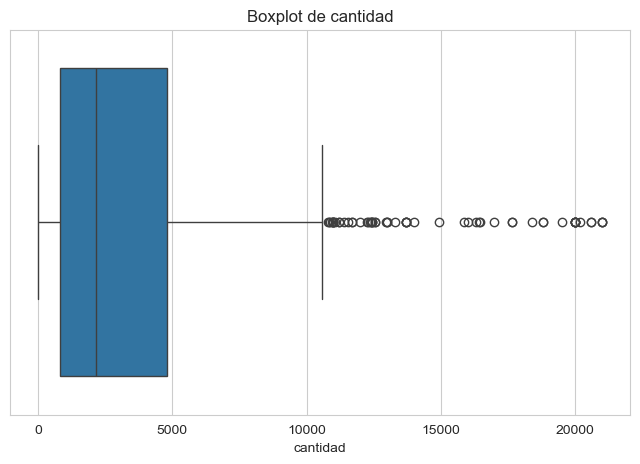

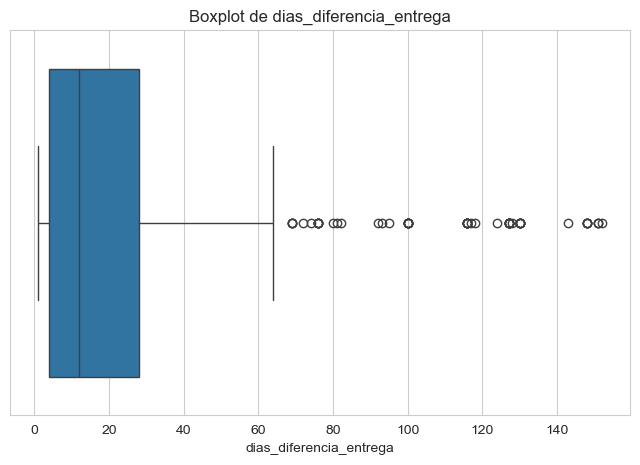

In [69]:
# Gráficos de Cajas (Boxplots) para detectar outliers
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_incumplio[column])
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
    plt.show()

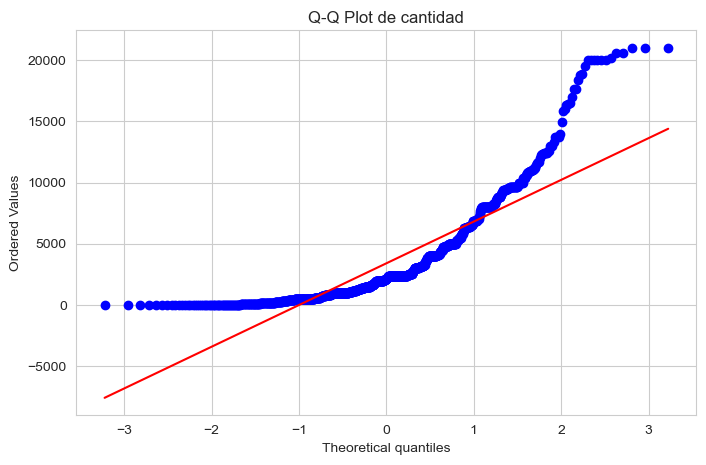

Prueba de Shapiro-Wilk para cantidad: Estadístico=0.7781238555908203, p-valor=3.6324145798202917e-36
cantidad no sigue una distribución normal (se rechaza la hipótesis nula)


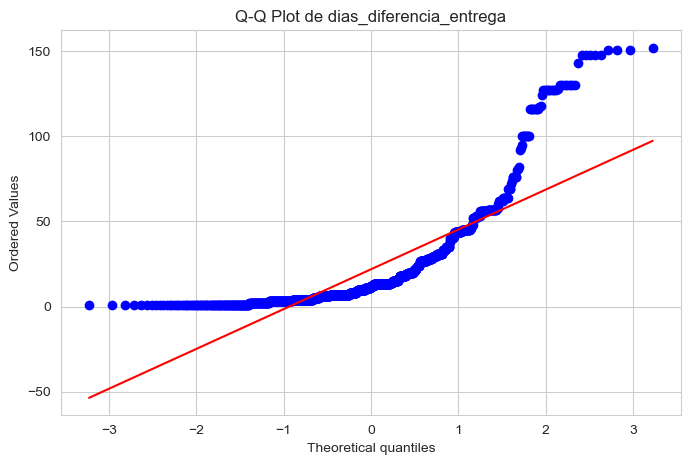

Prueba de Shapiro-Wilk para dias_diferencia_entrega: Estadístico=0.6975785493850708, p-valor=1.679946663955807e-40
dias_diferencia_entrega no sigue una distribución normal (se rechaza la hipótesis nula)
Estadísticas descriptivas:
           cantidad  dias_diferencia_entrega
count   1101.000000              1101.000000
mean    3405.703906                21.890100
std     3852.582114                27.960812
min        1.000000                 1.000000
25%      800.000000                 4.000000
50%     2150.000000                12.000000
75%     4800.000000                28.000000
max    21000.000000               152.000000
cantidad - Asimetría: 2.0014864830607237, Curtosis: 4.649683252249988
dias_diferencia_entrega - Asimetría: 2.4405690995028717, Curtosis: 6.513826848161818


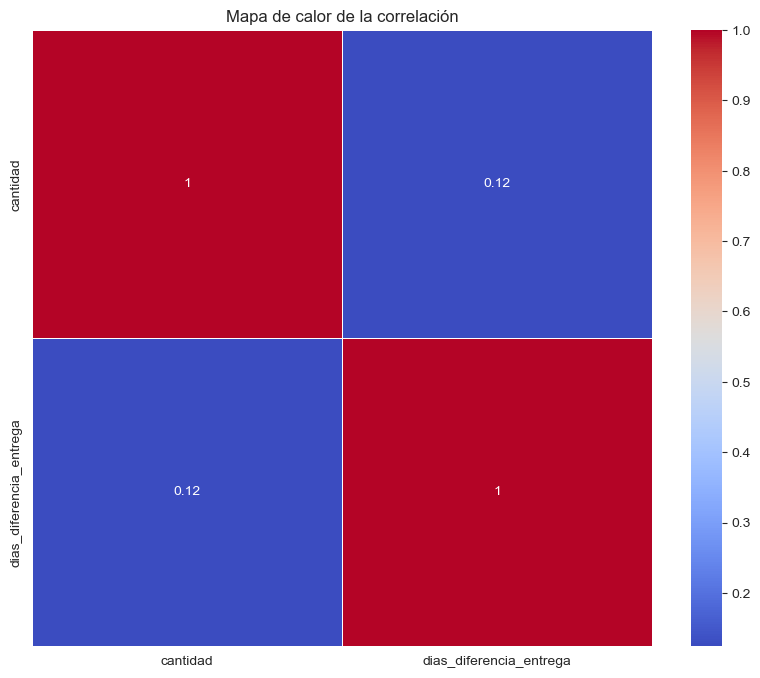

In [70]:
# Verificación de normalidad con Q-Q plots y Shapiro-Wilk
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    stats.probplot(df_incumplio[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot de {column}')
    plt.show()

    # Prueba de Shapiro-Wilk
    stat, p = stats.shapiro(df_incumplio[column])
    print(f'Prueba de Shapiro-Wilk para {column}: Estadístico={stat}, p-valor={p}')
    if p > 0.05:
        print(f'{column} parece seguir una distribución normal (no se rechaza la hipótesis nula)')
    else:
        print(f'{column} no sigue una distribución normal (se rechaza la hipótesis nula)')

# Estadísticas Descriptivas
desc_stats = df_incumplio[numerical_columns].describe()
print("Estadísticas descriptivas:")
print(desc_stats)

# Asimetría y Curtosis
for column in numerical_columns:
    skewness = df_incumplio[column].skew()
    kurtosis = df_incumplio[column].kurt()
    print(f'{column} - Asimetría: {skewness}, Curtosis: {kurtosis}')

# Análisis de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_incumplio[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de la correlación')
plt.show()

## DATA SET DE ENTRANAMIENTO

Una vez se identifica de forma clara que hay potencial de relacion y simplificando toda la informacion del dataset nos ponemos a disponer los datos para realizar los experiementos de Machine Learning, para ello la idea es eliminar la informacion que no es reelevante desde el punto de vista de la prediccion y las variables que se tienen 

In [71]:
df_incumplio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1101 entries, 4 to 9791
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   fecha_aproximada_necesidad  1101 non-null   datetime64[ns]
 1   dia_semana_aproximado       1101 non-null   object        
 2   mes_aproximado              1101 non-null   object        
 3   año_aproximado              1101 non-null   int64         
 4   cantidad                    1101 non-null   float64       
 5   pais                        1101 non-null   object        
 6   forma_envio                 1101 non-null   object        
 7   unidad_de_medida/U          1101 non-null   object        
 8   terminos_de_pago            1101 non-null   object        
 9   categoria_                  1101 non-null   object        
 10  cumplio                     1101 non-null   int64         
 11  dias_diferencia_entrega     1101 non-null   int64         
dt

In [72]:
# Convertir mes_aproximado a mes numérico
df_incumplio['mes_aproximado'] = pd.to_datetime(df_incumplio['mes_aproximado'], format='%B').dt.month

# Extraer el día del mes de fecha_aproximada_necesidad
df_incumplio['dia_aproximado'] = pd.to_datetime(df_incumplio['fecha_aproximada_necesidad']).dt.day


C:\Users\quint\AppData\Local\Temp\ipykernel_13980\4084653677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incumplio['mes_aproximado'] = pd.to_datetime(df_incumplio['mes_aproximado'], format='%B').dt.month
C:\Users\quint\AppData\Local\Temp\ipykernel_13980\4084653677.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incumplio['dia_aproximado'] = pd.to_datetime(df_incumplio['fecha_aproximada_necesidad']).dt.day


In [73]:
df_incumplio = df_incumplio.drop(columns=['cumplio', 'terminos_de_pago', 'pais', 'año_aproximado', 'dia_semana_aproximado', 'fecha_aproximada_necesidad'])
df_incumplio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1101 entries, 4 to 9791
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mes_aproximado           1101 non-null   int32  
 1   cantidad                 1101 non-null   float64
 2   forma_envio              1101 non-null   object 
 3   unidad_de_medida/U       1101 non-null   object 
 4   categoria_               1101 non-null   object 
 5   dias_diferencia_entrega  1101 non-null   int64  
 6   dia_aproximado           1101 non-null   int32  
dtypes: float64(1), int32(2), int64(1), object(3)
memory usage: 60.2+ KB


In [75]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df_incumplio.drop('dias_diferencia_entrega', axis=1)
y = df_incumplio['dias_diferencia_entrega']

# Separar las características numéricas y categóricas
numeric_features = ['mes_aproximado', 'cantidad', 'dia_aproximado']
categorical_features = ['forma_envio', 'unidad_de_medida/U', 'categoria_']

# Crear los transformadores para las características numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Crear el preprocesador utilizando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Aplicar el preprocesador a los datos de entrenamiento y prueba
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


ValueError: Found unknown categories ['ACERO, HIERRO, ALUMINIO (PLATINERIA, FLEJES Y VARILLAS, CANALES DE SECCIONADOR, LÁMINAS)'] in column 2 during transform